In [3]:
import glob
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
from tqdm import tqdm
import pandas as pd
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers.merge import add
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector, Activation,Dropout,Input
from keras.optimizers import Adam, RMSprop,SGD
from keras.layers.wrappers import Bidirectional
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image

Using TensorFlow backend.


In [5]:
token = 'Flickr8k.token.txt'

In [16]:
captions = open(token, 'r').read().strip().split('\n')

In [18]:
print(captions[0])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .


In [17]:
d = {}
for i, row in enumerate(captions):
    row = row.split('\t')
    row[0] = row[0][:len(row[0])-2]
    if row[0] in d:
        d[row[0]].append(row[1])
    else:
        d[row[0]] = [row[1]]

In [19]:
d['1000268201_693b08cb0e.jpg']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [1]:
images = 'Flicker8k_Dataset/'
len(images)

18

In [4]:
img = glob.glob(images+'*.jpg')
len(img)

8091

In [42]:
img[:5]

['Flicker8k_Dataset\\1000268201_693b08cb0e.jpg',
 'Flicker8k_Dataset\\1001773457_577c3a7d70.jpg',
 'Flicker8k_Dataset\\1002674143_1b742ab4b8.jpg',
 'Flicker8k_Dataset\\1003163366_44323f5815.jpg',
 'Flicker8k_Dataset\\1007129816_e794419615.jpg']

In [43]:
train_images_file = 'Flickr_8k.trainImages.txt'

In [44]:
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))

In [45]:
def split_data(l):
    temp = []
    for i in img:
        if i[len(images):] in l:
            temp.append(i)
    return temp

In [46]:
train_img = split_data(train_images)
len(train_img)

6000

In [47]:
val_images_file = 'Flickr_8k.devImages.txt'
val_images = set(open(val_images_file, 'r').read().strip().split('\n'))
val_img = split_data(val_images)
len(val_img)

1000

In [48]:
test_images_file = 'Flickr_8k.testImages.txt'
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))
test_img = split_data(test_images)
len(test_img)

1000

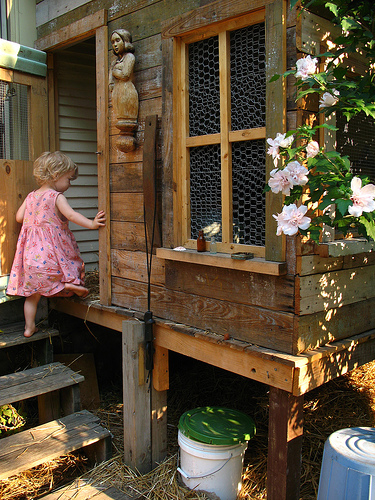

In [49]:
Image.open(train_img[0])

In [50]:
def preprocess_input(x):
    x/=255
    x-=0.5
    x*=2
    return x

In [51]:
IMG_SIZE=299
def preprocess(img_path):
    img=image.load_img(img_path,target_size=(IMG_SIZE,IMG_SIZE))
    x=image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x=preprocess_input(x)
    return x


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


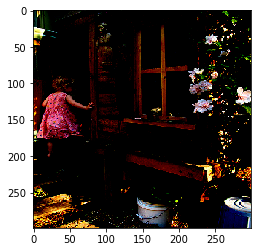

In [52]:
plt.imshow(np.squeeze(preprocess(train_img[0])))

In [57]:
model=InceptionV3(weights='imagenet')
from keras.models import Model

new_input = model.input
hidden_layer = model.layers[-2].output

model_new = Model(new_input, hidden_layer)

75890688/96112376 [======================>.......] - ETA: 3:20:0 - ETA: 1:33:2 - ETA: 1:19:5 - ETA: 1:14:2 - ETA: 1:06:5 - ETA: 1:01:5 - ETA: 58:30  - ETA: 56:0 - ETA: 56:2 - ETA: 47:1 - ETA: 46:4 - ETA: 39:5 - ETA: 35:3 - ETA: 32:3 - ETA: 28:5 - ETA: 24:1 - ETA: 21:1 - ETA: 18:1 - ETA: 16:5 - ETA: 16:1 - ETA: 16:2 - ETA: 14:1 - ETA: 14:1 - ETA: 12:4 - ETA: 12:1 - ETA: 12:0 - ETA: 11:5 - ETA: 11:2 - ETA: 11:1 - ETA: 10:4 - ETA: 10:3 - ETA: 10:2 - ETA: 10:1 - ETA: 10:1 - ETA: 10:0 - ETA: 9:5 - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 8: - ETA: 8: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ET

In [58]:
tryi = model_new.predict(preprocess(train_img[0]))
tryi.shape

(1, 2048)

In [59]:
def encode(image):
    image = preprocess(image)
    temp_enc = model_new.predict(image)
    temp_enc = np.reshape(temp_enc, temp_enc.shape[1])
    return temp_enc

In [60]:
encoding_train = {}
for img in tqdm(train_img):
    encoding_train[img[len(images):]] = encode(img)

100%|██████████████████████████████████████████████████████████████████████████████| 6000/6000 [44:52<00:00,  2.16it/s]


In [61]:
with open("encoded_images_inceptionV3.p", "wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle)

In [62]:
encoding_train = pickle.load(open('encoded_images_inceptionV3.p', 'rb'))
encoding_train['3556792157_d09d42bef7.jpg'].shape

(2048,)

In [63]:
encoding_test = {}
for img in tqdm(test_img):
    encoding_test[img[len(images):]] = encode(img)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [08:14<00:00,  1.03it/s]


In [64]:
with open("encoded_images_test_inceptionV3.p", "wb") as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle)
encoding_test = pickle.load(open('encoded_images_test_inceptionV3.p', 'rb'))

In [65]:
train_d = {}
for i in train_img:
    if i[len(images):] in d:
        train_d[i] = d[i[len(images):]]

In [66]:
len(train_d)

6000

In [69]:
val_d = {}
for i in val_img:
    if i[len(images):] in d:
        val_d[i] = d[i[len(images):]]

In [70]:
test_d = {}
for i in test_img:
    if i[len(images):] in d:
        test_d[i] = d[i[len(images):]]

In [71]:
caps = []
for key, val in train_d.items():
    for i in val:
        caps.append('<start> ' + i + ' <end>')

In [72]:
words = [i.split() for i in caps]
unique = []
for i in words:
    unique.extend(i)

In [73]:
unique = list(set(unique))

In [75]:
len(unique)

8256

In [76]:
word2idx = {val:index for index, val in enumerate(unique)}

In [77]:
word2idx['<start>']

6707

In [78]:
idx2word = {index:val for index, val in enumerate(unique)}
idx2word[6707]

'<start>'

In [80]:
max_len = 0
for c in caps:
    c=c.split()
    if len(c) > max_len:
        max_len = len(c)
max_len

40

In [81]:
vocab_size = len(unique)

In [83]:
f = open('flickr8k_training_dataset.txt', 'w')
f.write("image_id\tcaptions\n")

18

In [84]:
for key, val in train_d.items():
    for i in val:
        f.write(key[len(images):] + "\t" + "<start> " + i +" <end>" + "\n")

f.close()

In [85]:
df = pd.read_csv('flickr8k_training_dataset.txt', delimiter='\t')

In [86]:
len(df)

30000

In [87]:
c = [i for i in df['captions']]
len(c)

30000

In [88]:
imgs = [i for i in df['image_id']]

In [89]:
a = c[-1]
a, imgs[-1]

('<start> Woman writing on a pad in room with gold , decorated walls . <end>',
 '997338199_7343367d7f.jpg')

In [90]:
for i in a.split():
    print (i, "=>", word2idx[i])

<start> => 6707
Woman => 3029
writing => 5613
on => 2179
a => 4368
pad => 6460
in => 7316
room => 170
with => 5295
gold => 4665
, => 7714
decorated => 5460
walls => 679
. => 7468
<end> => 450


In [91]:
samples_per_epoch = 0
for ca in caps:
    samples_per_epoch += len(ca.split())-1

In [92]:
samples_per_epoch

383454

In [99]:
def data_generator(batch_size = 32):
        partial_caps = []
        next_words = []
        images = []
        
        df = pd.read_csv('flickr8k_training_dataset.txt', delimiter='\t')
        df = df.sample(frac=1)
        iter = df.iterrows()
        c = []
        imgs = []
        for i in range(df.shape[0]):
            x=next(iter)
            c.append(x[1][1])
            imgs.append(x[1][0])
            
        count=0
        while True:
            for j, text in enumerate(c):
                current_image = encoding_train[imgs[j]]
                for i in range(len(text.split())-1):
                    count+=1
                    
                    partial = [word2idx[txt] for txt in text.split()[:i+1]]
                    partial_caps.append(partial)
                    
                    # Initializing with zeros to create a one-hot encoding matrix
                    # This is what we have to predict
                    # Hence initializing it with vocab_size length
                    n = np.zeros(vocab_size)
                    # Setting the next word to 1 in the one-hot encoded matrix
                    n[word2idx[text.split()[i+1]]] = 1
                    next_words.append(n)
                    
                    images.append(current_image)

                    if count>=batch_size:
                        next_words = np.asarray(next_words)
                        images = np.asarray(images)
                        partial_caps = sequence.pad_sequences(partial_caps, maxlen=max_len, padding='post')
                        yield [[images, partial_caps], next_words]
                        partial_caps = []
                        next_words = []
                        images = []
                        count = 0

In [141]:
embedding_size = 300

In [142]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
image_model=RepeatVector(max_len)(fe2)

In [143]:
inputs2=Input(shape=(max_len,))
se1 = Embedding(vocab_size, embedding_size, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
caption_model = LSTM(256,return_sequences=True)(se2)


In [144]:
decoder1 = add([image_model,caption_model])
decoder2 = Dense(256, activation='relu')(decoder1)
decoder3 =Bidirectional(LSTM(256, return_sequences=False))(decoder2)
outputs = Dense(vocab_size, activation='softmax')(decoder3)
final_model=Model(inputs=[inputs1, inputs2], outputs=outputs)

In [145]:
final_model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])

In [146]:
final_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 2048)         0                                            
__________________________________________________________________________________________________
input_14 (InputLayer)           (None, 40)           0                                            
__________________________________________________________________________________________________
dropout_10 (Dropout)            (None, 2048)         0           input_13[0][0]                   
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 40, 300)      2476800     input_14[0][0]                   
__________________________________________________________________________________________________
dense_16 (

In [150]:
final_model.fit_generator(data_generator(batch_size=128), steps_per_epoch=samples_per_epoch/128, epochs=1, 
                          verbose=2)

Epoch 1/1
 - 4686s - loss: 3.4616 - acc: 0.3774


In [152]:
final_model.fit_generator(data_generator(batch_size=128), steps_per_epoch=samples_per_epoch/128, epochs=1, 
                          verbose=2)

Epoch 1/1
 - 3287s - loss: 3.3260 - acc: 0.4021


In [153]:
final_model.save_weights('loss_2.h5')

In [154]:
final_model.load_weights('loss_2.h5')

In [155]:
final_model.fit_generator(data_generator(batch_size=128), steps_per_epoch=samples_per_epoch/128, epochs=1, 
                          verbose=2)

Epoch 1/1
 - 3350s - loss: 3.3111 - acc: 0.4068


In [156]:
final_model.fit_generator(data_generator(batch_size=128), steps_per_epoch=samples_per_epoch/128, epochs=1, 
                          verbose=2)

Epoch 1/1
 - 3484s - loss: 3.2886 - acc: 0.4095


In [157]:
final_model.save_weights('loss_4.h5')

In [158]:
final_model.load_weights('loss_2.h5')

In [162]:
SGD(lr=0.01)
final_model.fit_generator(data_generator(batch_size=256), steps_per_epoch=samples_per_epoch/256, epochs=1, 
                          verbose=2)

Epoch 1/1
 - 3043s - loss: 3.1449 - acc: 0.4167


In [163]:
final_model.fit_generator(data_generator(batch_size=256), steps_per_epoch=samples_per_epoch/256, epochs=1, 
                          verbose=2)

Epoch 1/1
 - 3284s - loss: 3.1145 - acc: 0.4218


In [164]:
final_model.optimizer.lr = 1e-4
final_model.fit_generator(data_generator(batch_size=512), steps_per_epoch=samples_per_epoch/512, epochs=1, 
                          verbose=2)

Epoch 1/1
 - 3295s - loss: 2.9665 - acc: 0.4311


In [165]:
final_model.save_weights('loss_7.h5')

In [166]:
final_model.load_weights('loss_7.h5')

In [167]:
final_model.fit_generator(data_generator(batch_size=512), steps_per_epoch=samples_per_epoch/512, epochs=3, 
                          verbose=2)

Epoch 1/3
 - 2639s - loss: 2.8629 - acc: 0.4375
Epoch 2/3
 - 2580s - loss: 2.8273 - acc: 0.4436
Epoch 3/3
 - 2591s - loss: 2.7673 - acc: 0.4484


In [168]:
final_model.save_weights('loss_10.h5')

In [169]:
final_model.load_weights('loss_10.h5')

In [170]:
final_model.fit_generator(data_generator(batch_size=1024), steps_per_epoch=samples_per_epoch/1024, epochs=1, 
                          verbose=2)

Epoch 1/1
 - 2534s - loss: 2.6689 - acc: 0.4559


In [171]:
final_model.fit_generator(data_generator(batch_size=1024), steps_per_epoch=samples_per_epoch/1024, epochs=3, 
                          verbose=2)

Epoch 1/3
 - 2538s - loss: 2.6019 - acc: 0.4613
Epoch 2/3
 - 2523s - loss: 2.5563 - acc: 0.4661
Epoch 3/3
 - 2522s - loss: 2.5043 - acc: 0.4715


In [172]:
final_model.fit_generator(data_generator(batch_size=1024), steps_per_epoch=samples_per_epoch/1024, epochs=1, 
                          verbose=2)

Epoch 1/1
 - 2540s - loss: 2.4769 - acc: 0.4751


In [173]:
final_model.save_weights('loss_15.h5')

In [174]:
final_model.load_weights('loss_15.h5')

In [179]:
def predictions(image):
    start_word = ["<start>"]
    while True:
        partial_caps = [word2idx[i] for i in start_word]
        partial_caps = sequence.pad_sequences([partial_caps], maxlen=max_len, padding='post')
        e = encoding_test[image[len(images):]]
        preds = final_model.predict([np.array([e]), np.array(partial_caps)])
        word_pred = idx2word[np.argmax(preds[0])]
        start_word.append(word_pred)
        
        if word_pred == "<end>" or len(start_word) > max_len:
            break
            
    return ' '.join(start_word[1:-1])

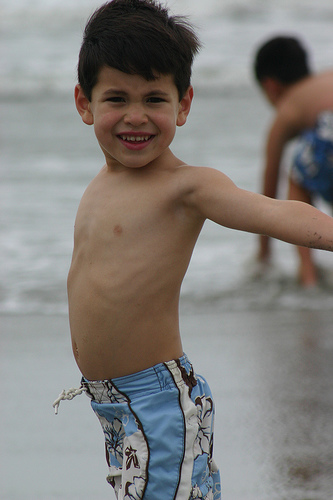

In [181]:
try_image = test_img[1]
Image.open(try_image)

In [182]:
print("Normal predicted caption:",predictions(try_image))

Normal predicted caption: A young boy in a blue shirt is standing in the water .


In [183]:
def beam_search_predictions(image,beam_index):
    start=[word2idx['<start>']]
    start_word = [[start, 0.0]]
    
    while len(start_word[0][0]) < max_len:
        temp = []
        for s in start_word:
            par_caps = sequence.pad_sequences([s[0]], maxlen=max_len, padding='post')
            e = encoding_test[image[len(images):]]
            preds = final_model.predict([np.array([e]), np.array(par_caps)])
            
            word_preds = np.argsort(preds[0])[-beam_index:]
            # Getting the top <beam_index> predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    start_word = start_word[-1][0]
    intermediate_caption = [idx2word[i] for i in start_word]

    final_caption = []
    
    for i in intermediate_caption:
        if i != '<end>':
            final_caption.append(i)
        else:
            break
    
    final_caption = ' '.join(final_caption[1:])
    return final_caption
    

In [185]:
print("Beam-search caption:",beam_search_predictions(try_image,beam_index=3))
print("Beam-search caption:",beam_search_predictions(try_image,beam_index=5))

Beam-search caption: A young boy in a blue bathing suit plays in the water .
Beam-search caption: A little girl in a bathing suit plays in the water .


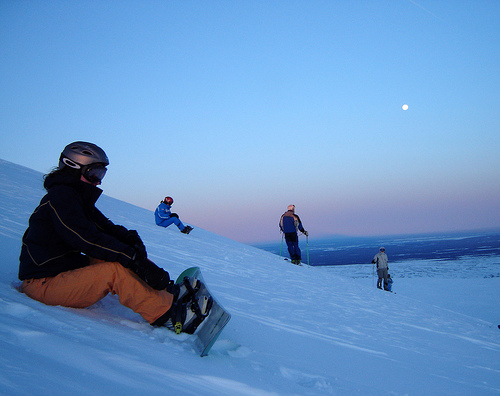

In [189]:
img2=test_img[10]
Image.open(img2)

In [188]:

print("Normal predicted caption:",predictions(img2))
print("Beam-search caption:",beam_search_predictions(img2,beam_index=3))
print("Beam-search caption:",beam_search_predictions(img2,beam_index=5))

Normal predicted caption: A man in a red jacket is skiing on a red snowboard .
Beam-search caption: A man in a red jacket is in the snow .
Beam-search caption: A man in a red jacket is in the snow .


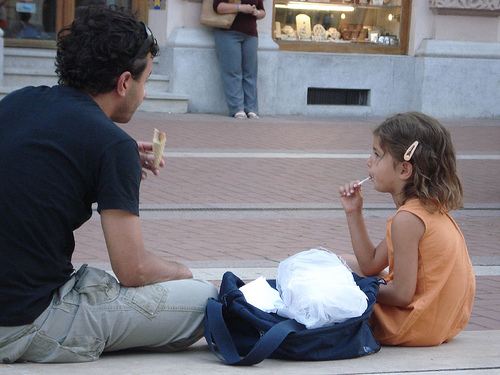

In [190]:
img3=test_img[100]
Image.open(img3)

In [191]:
print("Normal predicted caption:",predictions(img3))
print("Beam-search caption:",beam_search_predictions(img3,beam_index=3))
print("Beam-search caption:",beam_search_predictions(img3,beam_index=5))

Normal predicted caption: A group of children sit on a bench .
Beam-search caption: A group of children sit on a bench in front of a brick wall .
Beam-search caption: A group of people sit on a bench in front of a brick wall .


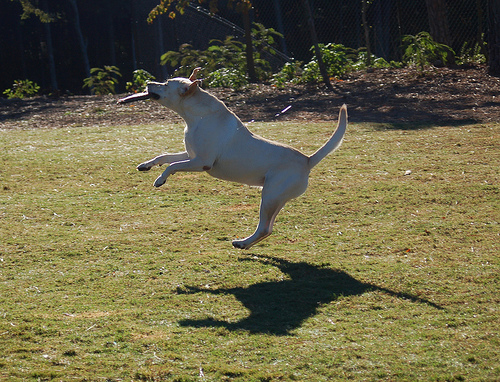

In [196]:
img4="Flicker8k_Dataset/1674612291_7154c5ab61.jpg"
Image.open(img4)

In [197]:
print("Normal predicted caption:",predictions(img4))
print("Beam-search caption:",beam_search_predictions(img4,beam_index=3))
print("Beam-search caption:",beam_search_predictions(img4,beam_index=5))

Normal predicted caption: A dog runs on the grass .
Beam-search caption: A white dog and a black and white dog are running in the grass .
Beam-search caption: A white dog and a black and white dog are running in the grass .
